# VIDEO SUMMARIZATION



####            Video summarization is the process of automatically generating a textual representation of a video that captures its most crucial details 

## Importing packages

In [40]:
import numpy as np
from PIL import Image
import os
import cv2
import time
import string
from pickle import dump
from pickle import load
from tensorflow.keras.applications.xception import Xception #to get pre-trained model Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer #for text tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense#Keras to build our CNN and LSTM
from tensorflow.keras.layers import LSTM, Embedding, Dropout

## Data cleaning

In [41]:
# Load the document file and read the content
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [42]:
# to create description dictioonary that will map the captions
def img_capt(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:]:
        img, caption = caption.split("    ")
        if img not in descriptions:
            descriptions[img] = [ caption ]
        else:
            descriptions[img].append(caption)
    return descriptions

In [43]:
#cleaning the textual data
def txt_clean(captions):
    table = str.maketrans('', '', string.punctuation)
    for img, caps in captions.items():
        for i, img_caption in enumerate(caps):
            img_caption.replace("-", " ")
            descp = img_caption.split()
            # uppercase to lowercase
            descp = [wrd.lower() for wrd in descp]
            # remove punctuation from each token
            descp = [wrd.translate(table) for wrd in descp]
            # remove hanging 's and a
            descp = [wrd for wrd in descp if(len(wrd) > 1)]
            # remove words containing numbers with them
            descp = [wrd for wrd in descp if(wrd.isalpha())]
            # converting back to string
            img_caption = ' '.join(descp)
            captions[img][i] = img_caption
    return captions

In [44]:
def txt_vocab(descriptions):
  # To build vocab of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

In [45]:
## to store descriptions into a file
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '    ' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [46]:
dataset_text = "D:/nlp/videosummarization_dataset/train/annotation"
dataset_images = "D:/nlp/videosummarization_dataset/train/all_frames"

In [47]:
filename = dataset_text + "\\" + "descriptions.txt"
descriptions = img_capt(filename)
print("Length of descriptions =" ,len(descriptions))
clean_descriptions = txt_clean(descriptions)
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 502
Length of vocabulary =  350


In [48]:
vocabulary

{'about',
 'adult',
 'after',
 'again',
 'an',
 'and',
 'appreciated',
 'approaches',
 'approaching',
 'are',
 'around',
 'as',
 'asking',
 'at',
 'attempt',
 'away',
 'baby',
 'back',
 'ball',
 'bare',
 'barn',
 'be',
 'bear',
 'bearlike',
 'bearlooking',
 'because',
 'becomes',
 'bed',
 'behind',
 'black',
 'boat',
 'boots',
 'both',
 'box',
 'boy',
 'boys',
 'bread',
 'brings',
 'building',
 'bull',
 'bush',
 'buying',
 'by',
 'came',
 'camera',
 'can',
 'candies',
 'candy',
 'carries',
 'cat',
 'chair',
 'chasing',
 'check',
 'chest',
 'child',
 'clean',
 'clicks',
 'closer',
 'clouds',
 'clutching',
 'come',
 'comes',
 'coming',
 'cone',
 'confused',
 'costume',
 'counting',
 'crawling',
 'cream',
 'creature',
 'cries',
 'crying',
 'cunningly',
 'die',
 'digging',
 'digs',
 'dipped',
 'dips',
 'disappeared',
 'doesnt',
 'dog',
 'dogs',
 'door',
 'down',
 'drink',
 'drinking',
 'drinks',
 'driving',
 'drops',
 'during',
 'each',
 'eating',
 'eats',
 'editing',
 'empty',
 'end',
 'e

In [49]:
descriptions

{'frame1.jpg': ['toy'],
 'frame2.jpg': ['toy'],
 'frame3.jpg': ['baby crawling toward the toy'],
 'frame4.jpg': ['baby crawling toward the toy'],
 'frame5.jpg': ['baby crawling toward the toy'],
 'frame6.jpg': ['baby crawling toward the toy'],
 'frame7.jpg': ['baby crawling toward the toy'],
 'frame8.jpg': ['baby picks up the toy'],
 'frame9.jpg': ['baby picks up the toy'],
 'frame10.jpg': ['baby picks up the toy'],
 'frame11.jpg': ['baby shakes the toy'],
 'frame12.jpg': ['baby shakes the toy'],
 'frame13.jpg': ['baby takes in the toy'],
 'frame14.jpg': ['baby becomes boy'],
 'frame15.jpg': ['the boy starts walking'],
 'frame16.jpg': ['the boy starts running'],
 'frame17.jpg': ['the boy runs'],
 'frame18.jpg': ['the boy runs'],
 'frame19.jpg': ['the boy sees the red ball'],
 'frame20.jpg': ['the boy throws the red ball'],
 'frame21.jpg': ['the boy plays with the ball'],
 'frame22.jpg': ['the boy takes in the ball'],
 'frame23.jpg': ['the boy becomes the adult'],
 'frame24.jpg': ['the 

## Feature Extraction

In [15]:
def extract_features(directory):
    model = Xception(include_top=False, pooling='avg')
    features = {}
    ct=0
    for pic in os.listdir(directory):
        file = directory + "\\" + pic
        image = Image.open(file)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        features[pic] = feature
        ct+=1
        print(ct)
    return features

In [16]:
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))
features = load(open("features.p","rb"))

In [17]:
features

{'frame1.jpg': array([[3.6402344e-05, 3.0143207e-03, 5.4958326e-01, ..., 1.5433324e-02,
         0.0000000e+00, 1.5803766e-02]], dtype=float32),
 'frame10.jpg': array([[0.32209066, 0.22511694, 0.00227418, ..., 0.14896946, 0.02045721,
         0.01121851]], dtype=float32),
 'frame100.jpg': array([[0.        , 0.1757792 , 0.        , ..., 0.        , 0.29437703,
         0.29392302]], dtype=float32),
 'frame101.jpg': array([[8.058548e-05, 8.020172e-03, 2.452965e-02, ..., 0.000000e+00,
         0.000000e+00, 4.775607e-03]], dtype=float32),
 'frame102.jpg': array([[0.08271903, 0.04779911, 0.42965847, ..., 0.        , 0.05150607,
         0.0564553 ]], dtype=float32),
 'frame103.jpg': array([[0.04757471, 0.0033755 , 0.5080733 , ..., 0.03361735, 0.02803729,
         0.40148908]], dtype=float32),
 'frame104.jpg': array([[0.12117107, 0.        , 0.05688269, ..., 0.        , 0.34398544,
         0.26102808]], dtype=float32),
 'frame105.jpg': array([[0.02038528, 0.01852702, 0.58143026, ..., 0.09

## Loading dataset for model training

In [50]:
train_imgs=[]
for i in clean_descriptions:
    train_imgs+=[i]

In [51]:
train_imgs

['frame1.jpg',
 'frame2.jpg',
 'frame3.jpg',
 'frame4.jpg',
 'frame5.jpg',
 'frame6.jpg',
 'frame7.jpg',
 'frame8.jpg',
 'frame9.jpg',
 'frame10.jpg',
 'frame11.jpg',
 'frame12.jpg',
 'frame13.jpg',
 'frame14.jpg',
 'frame15.jpg',
 'frame16.jpg',
 'frame17.jpg',
 'frame18.jpg',
 'frame19.jpg',
 'frame20.jpg',
 'frame21.jpg',
 'frame22.jpg',
 'frame23.jpg',
 'frame24.jpg',
 'frame25.jpg',
 'frame26.jpg',
 'frame27.jpg',
 'frame28.jpg',
 'frame29.jpg',
 'frame30.jpg',
 'frame31.jpg',
 'frame32.jpg',
 'frame33.jpg',
 'frame34.jpg',
 'frame35.jpg',
 'frame36.jpg',
 'frame37.jpg',
 'frame38.jpg',
 'frame39.jpg',
 'frame40.jpg',
 'frame41.jpg',
 'frame42.jpg',
 'frame43.jpg',
 'frame44.jpg',
 'frame45.jpg',
 'frame46.jpg',
 'frame47.jpg',
 'frame48.jpg',
 'frame49.jpg',
 'frame50.jpg',
 'frame51.jpg',
 'frame52.jpg',
 'frame53.jpg',
 'frame54.jpg',
 'frame55.jpg',
 'frame56.jpg',
 'frame57.jpg',
 'frame58.jpg',
 'frame59.jpg',
 'frame60.jpg',
 'frame61.jpg',
 'frame62.jpg',
 'frame63.jpg',
 

In [20]:
def load_clean_descriptions(filename, photos):
    # Load clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    ct=0
    for line in file.split("\n"):

        words = line.split()
        if len(words) < 2:
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = ' ' + " ".join(image_caption) + ' '
            descriptions[image].append(desc)
        ct+=1
    return descriptions

In [21]:
def load_features(photos):
    # Load all features
    all_features = load(open("features.p","rb"))
    features = {k:all_features[k] for k in photos}
    return features

In [22]:
filename = dataset_text + "/" + "descriptions.txt"
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [23]:
train_descriptions

{'frame1.jpg': [' toy '],
 'frame2.jpg': [' toy '],
 'frame3.jpg': [' baby crawling toward the toy '],
 'frame4.jpg': [' baby crawling toward the toy '],
 'frame5.jpg': [' baby crawling toward the toy '],
 'frame6.jpg': [' baby crawling toward the toy '],
 'frame7.jpg': [' baby crawling toward the toy '],
 'frame8.jpg': [' baby picks up the toy '],
 'frame9.jpg': [' baby picks up the toy '],
 'frame10.jpg': [' baby picks up the toy '],
 'frame11.jpg': [' baby shakes the toy '],
 'frame12.jpg': [' baby shakes the toy '],
 'frame13.jpg': [' baby takes in the toy '],
 'frame14.jpg': [' baby becomes boy '],
 'frame15.jpg': [' the boy starts walking '],
 'frame16.jpg': [' the boy starts running '],
 'frame17.jpg': [' the boy runs '],
 'frame18.jpg': [' the boy runs '],
 'frame19.jpg': [' the boy sees the red ball '],
 'frame20.jpg': [' the boy throws the red ball '],
 'frame21.jpg': [' the boy plays with the ball '],
 'frame22.jpg': [' the boy takes in the ball '],
 'frame23.jpg': [' the bo

In [24]:
train_features

{'frame1.jpg': array([[3.6402344e-05, 3.0143207e-03, 5.4958326e-01, ..., 1.5433324e-02,
         0.0000000e+00, 1.5803766e-02]], dtype=float32),
 'frame2.jpg': array([[0.        , 0.00357602, 0.54937816, ..., 0.01391389, 0.        ,
         0.01484338]], dtype=float32),
 'frame3.jpg': array([[0.        , 0.01684087, 0.4213964 , ..., 0.01015344, 0.14347717,
         0.03684738]], dtype=float32),
 'frame4.jpg': array([[0.09388548, 0.27060825, 0.28657284, ..., 0.13921702, 0.23920651,
         0.00058189]], dtype=float32),
 'frame5.jpg': array([[0.02629829, 0.15651968, 0.254145  , ..., 0.06331266, 0.1680693 ,
         0.        ]], dtype=float32),
 'frame6.jpg': array([[0.00436379, 0.14672188, 0.28761145, ..., 0.01116767, 0.181589  ,
         0.        ]], dtype=float32),
 'frame7.jpg': array([[0.01803185, 0.3688395 , 0.1573237 , ..., 0.        , 0.10457703,
         0.        ]], dtype=float32),
 'frame8.jpg': array([[1.9599738e-02, 3.8904122e-01, 6.6035382e-02, ..., 2.6275634e-04,
     

In [25]:
all_features = load(open("features.p","rb"))

In [26]:
train_descriptions = load_clean_descriptions(r"D:/nlp/videosummarization_dataset/train/annotation/descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

## Tokenizing the vocabulary

In [27]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        for d in descriptions[key]:
            all_desc.append(d)
    return all_desc

In [28]:
from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer


In [29]:
from pickle import dump
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1

In [30]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

In [31]:
desc_list = dict_to_list(train_descriptions)

In [32]:
desc_list

[' a toy ',
 ' a toy ',
 ' baby crawling toward the toy ',
 ' baby crawling toward the toy ',
 ' baby crawling toward the toy ',
 ' baby crawling toward the toy ',
 ' baby crawling toward the toy ',
 ' baby picks up the toy ',
 ' baby picks up the toy ',
 ' baby picks up the toy ',
 ' baby shakes the toy ',
 ' baby shakes the toy ',
 ' baby takes in the toy ',
 ' baby becomes a boy ',
 ' the boy starts walking ',
 ' the boy starts running ',
 ' the boy runs ',
 ' the boy runs ',
 ' the boy sees the red ball ',
 ' the boy throws the red ball ',
 ' the boy plays with the ball ',
 ' the boy takes in the ball ',
 ' the boy becomes the adult ',
 ' the boy starts walking ',
 ' the boy is walking ',
 ' the boy is walking ',
 ' the boy is walking ',
 ' the boy is walking toward the phone ',
 ' the boy sees the phone ',
 ' the boy picks up the phone ',
 ' the boy talks on the phone ',
 ' the boy talks on the phone ',
 ' the boy talks on the phone ',
 ' the boy takes in the phone ',
 ' the boy b

In [33]:
max_length = max_length(train_descriptions)
max_length #Max_length of description is 14

14

In [34]:
import pickle
with open('tokenizer.p', 'rb') as f:
    tokenizer = pickle.load(f)
for word, index in list(tokenizer.word_index.items()):
    print(f"{word}: {index}")


the: 1
boy: 2
is: 3
a: 4
man: 5
to: 6
walking: 7
cat: 8
at: 9
looks: 10
candy: 11
bear: 12
dog: 13
rat: 14
with: 15
and: 16
two: 17
polar: 18
toy: 19
dogs: 20
in: 21
girl: 22
on: 23
bread: 24
playing: 25
out: 26
looking: 27
starts: 28
old: 29
from: 30
toaster: 31
her: 32
mother: 33
takes: 34
bull: 35
he: 36
eats: 37
baby: 38
toward: 39
ball: 40
of: 41
running: 42
red: 43
stick: 44
it: 45
black: 46
screen: 47
down: 48
other: 49
away: 50
building: 51
train: 52
wings: 53
up: 54
shakes: 55
towards: 56
for: 57
licks: 58
eating: 59
cone: 60
no: 61
picks: 62
coming: 63
hand: 64
gives: 65
ice: 66
cream: 67
child: 68
shocked: 69
both: 70
runs: 71
walks: 72
toast: 73
together: 74
woman: 75
them: 76
scenery: 77
digging: 78
digs: 79
phone: 80
suitcase: 81
its: 82
turns: 83
comes: 84
machine: 85
around: 86
goes: 87
faster: 88
sheep: 89
pig: 90
clicks: 91
got: 92
window: 93
camera: 94
person's: 95
bush: 96
milk: 97
watching: 98
rain: 99
empty: 100
lady: 101
forward: 102
road: 103
something: 104
smil

In [35]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

352

In [36]:
seq = tokenizer.texts_to_sequences([desc_list[501]])
seq

[[1, 18, 12, 87, 130, 1, 106]]

In [37]:
[desc_list[501]]

[' the polar bear goes inside the village ']

## Defining the CNN-RNN model

### fine-tune

In [49]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, RepeatVector, concatenate, TimeDistributed, Activation, Dot
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Embedding, add, Flatten
from keras.models import Model
from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

def define_model(vocab_size, max_length):
    
    # features from the CNN model compressed from 2048 to 256 nodes
    # Load the InceptionV3 model with weights pre-trained on ImageNet
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    #bert_output = bert_model(inputs1)[1]

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))    
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    #se1 = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256, return_sequences=True)(se2)
    se4 = LSTM(256, return_sequences=True)(se3)
    se5 = LSTM(256, return_sequences=True)(se4)

    # Attention Mechanism
    attention = TimeDistributed(Dense(1))(se5)
    attention = Activation('softmax')(attention)
    se6 = Dot(axes=1)([se5, attention])
    se6 = Flatten()(se6)

    # Merging both models
    decoder1 = add([fe2, se6])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # merge it [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [50]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [51]:
print('Dataset: ', len(train_imgs)) #502
print('Descriptions: train=', len(train_descriptions)) #502
print('Photos: train=', len(train_features)) # 502
print('Vocabulary Size:', vocab_size) #351
print('Description Length: ', max_length) #14

Dataset:  502
Descriptions: train= 502
Photos: train= 502
Vocabulary Size: 352
Description Length:  14


## Creating a data generator

In [52]:
def data_generator(descriptions, photos, tokenizer, max_length, batch_size):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while True:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key][0]
            for desc in desc_list:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([desc])[0]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # batch size reached
            if n==batch_size:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n=0

## Training the model

In [53]:
model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
batch_size = 32

for i in range(epochs):
    print(i)
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, batch_size)
    model.fit_generator(generator, epochs=i+1, steps_per_epoch=steps//batch_size, verbose=1)
    model.save("models_v3/model_" + str(i) + ".h5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 14)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 14, 256)      90112       ['input_6[0][0]']                
                                                                                                  
 dropout_3 (Dropout)            (None, 14, 256)      0           ['embedding_1[0][0]']            
                                                                                                  
 lstm_3 (LSTM)                  (None, 14, 256)      525312      ['dropout_3[0][0]']              
                                                                                            

C:\Users\hebli\AppData\Local\Temp\ipykernel_3080\605854744.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=i+1, steps_per_epoch=steps//batch_size, verbose=1)


15/15 [==============================] - 31s 517ms/step - loss: 5.6194
1
Epoch 1/2
15/15 [==============================] - 8s 511ms/step - loss: 5.0810
Epoch 2/2
15/15 [==============================] - 8s 499ms/step - loss: 4.9034
2
Epoch 1/3
15/15 [==============================] - 8s 508ms/step - loss: 4.5903
Epoch 2/3
15/15 [==============================] - 8s 500ms/step - loss: 4.3334
Epoch 3/3
15/15 [==============================] - 8s 517ms/step - loss: 4.0588
3
Epoch 1/4
15/15 [==============================] - 7s 504ms/step - loss: 3.8413
Epoch 2/4
15/15 [==============================] - 8s 506ms/step - loss: 3.5607
Epoch 3/4
15/15 [==============================] - 8s 518ms/step - loss: 3.3247
Epoch 4/4
15/15 [==============================] - 8s 520ms/step - loss: 3.2041
4
Epoch 1/5
15/15 [==============================] - 8s 506ms/step - loss: 3.1204
Epoch 2/5
15/15 [==============================] - 8s 512ms/step - loss: 3.0948
Epoch 3/5
15/15 [========================

In [54]:
from keras.models import Model
# our model layers
def print_layer_info(model):
    for layer in model.layers:
        print(layer.name)
        print("Input shape: ", layer.input_shape)
        print("Output shape: ", layer.output_shape)
        print()

print_layer_info(model)

input_6
Input shape:  [(None, 14)]
Output shape:  [(None, 14)]

embedding_1
Input shape:  (None, 14)
Output shape:  (None, 14, 256)

dropout_3
Input shape:  (None, 14, 256)
Output shape:  (None, 14, 256)

lstm_3
Input shape:  (None, 14, 256)
Output shape:  (None, 14, 256)

lstm_4
Input shape:  (None, 14, 256)
Output shape:  (None, 14, 256)

lstm_5
Input shape:  (None, 14, 256)
Output shape:  (None, 14, 256)

time_distributed_1
Input shape:  (None, 14, 256)
Output shape:  (None, 14, 1)

input_5
Input shape:  [(None, 2048)]
Output shape:  [(None, 2048)]

activation_189
Input shape:  (None, 14, 1)
Output shape:  (None, 14, 1)

dropout_2
Input shape:  (None, 2048)
Output shape:  (None, 2048)

dot_1
Input shape:  [(None, 14, 256), (None, 14, 1)]
Output shape:  (None, 256, 1)

dense_4
Input shape:  (None, 2048)
Output shape:  (None, 256)

flatten_1
Input shape:  (None, 256, 1)
Output shape:  (None, 256)

add_1
Input shape:  [(None, 256), (None, 256)]
Output shape:  (None, 256)

dense_6
Input

In [55]:
def extract_features(img_path):
    model = Xception(include_top=False, pooling='avg')
    image = Image.open(img_path)
    image = image.resize((299,299))
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

def frame_extraction(path):
    # Read the video from specified path
    cam = cv2.VideoCapture(path)
    try:
        # creating a folder named data
        if not os.path.exists('D:/nlp/videosummarization_dataset/test/frames/v1'):
            os.makedirs('D:/nlp/videosummarization_dataset/test/frames/v1')
    except OSError:
        print ('Error: Creating directory of data')
    currentframe = 0
    fps = cam.get(cv2.CAP_PROP_FPS)
    delay = int(1000 / fps)  # delay in milliseconds for 1 frame per second
    while True:
        ret, frame = cam.read()
        if ret:
            if currentframe % int(fps) == 0:  # capture 1 frame per second
                name = 'D:/nlp/videosummarization_dataset/test/frames/v1/frame' + str(currentframe) + '.jpg'
                print ('Creating...' + name)
                cv2.imwrite(name, frame)
            currentframe += 1
            time.sleep(delay / 1000)
        else:
            break
    cam.release()
    cv2.destroyAllWindows()

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Inference

1/1 [==============================] - 2s 2s/step

 frame259.jpg : at laptop during during rain rain rain child


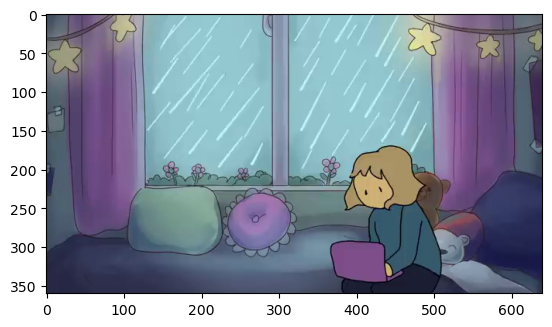

1/1 [==============================] - 2s 2s/step

 frame260.jpg : at laptop during during rain rain child child


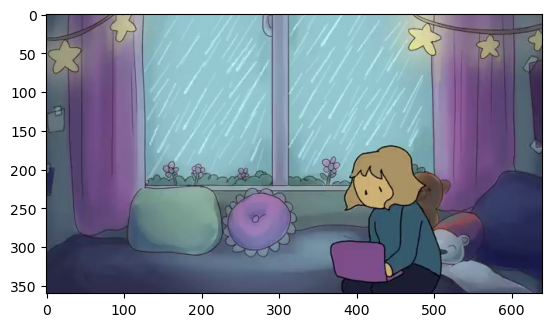

1/1 [==============================] - 2s 2s/step

 frame261.jpg : at to during during rain rain child child


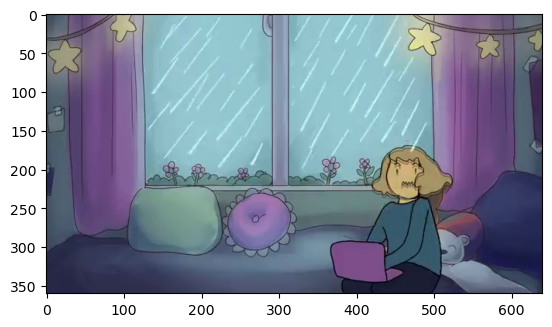

1/1 [==============================] - 2s 2s/step

 frame262.jpg : at to during during rain rain child child


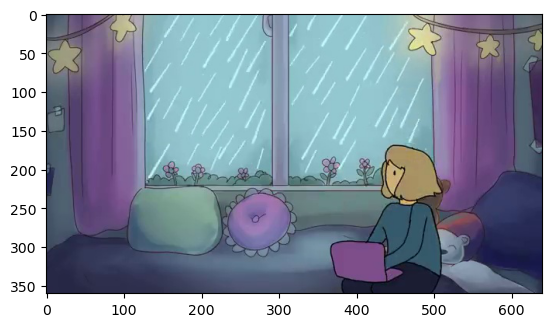

1/1 [==============================] - 2s 2s/step

 frame263.jpg : at to during during rain rain child child


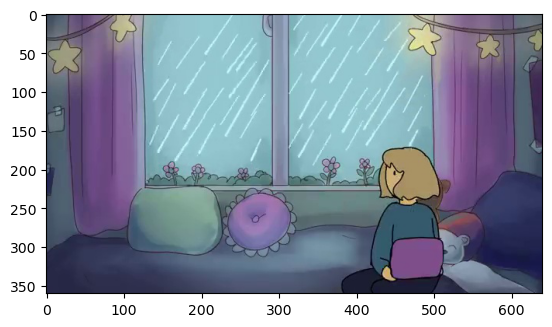

1/1 [==============================] - 3s 3s/step

 frame264.jpg : at to during during rain child child child


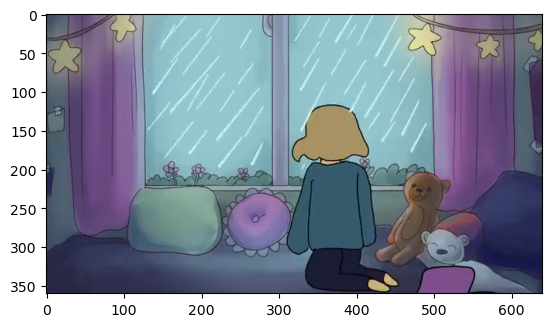

1/1 [==============================] - 2s 2s/step

 frame265.jpg : at to during during rain child child child


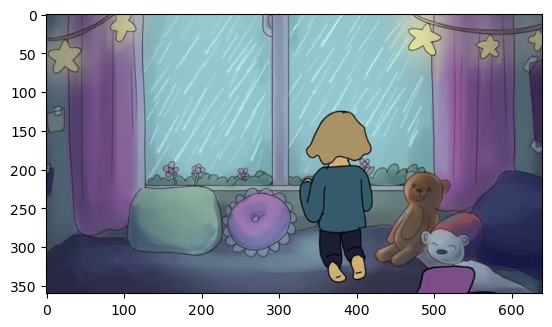

1/1 [==============================] - 2s 2s/step

 frame266.jpg : out the the window window the the the


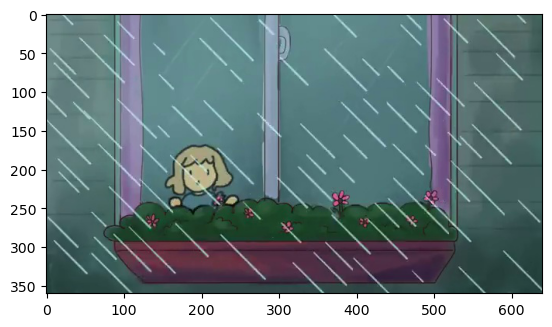

1/1 [==============================] - 2s 2s/step

 frame267.jpg : out the the window window the the the


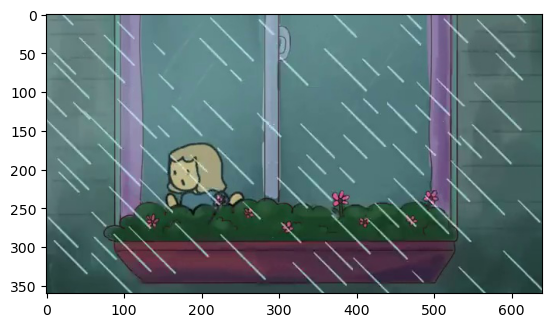

1/1 [==============================] - 2s 2s/step

 frame268.jpg : idea idea the the the the the the


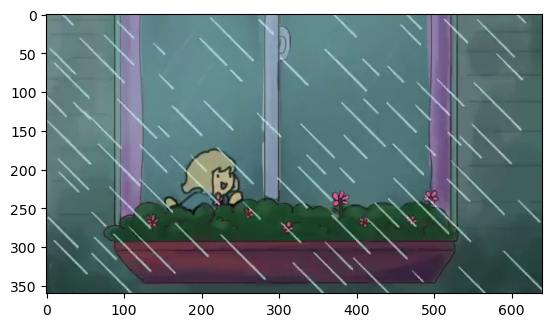

1/1 [==============================] - 2s 2s/step

 frame269.jpg : to get from from bed bed bed the


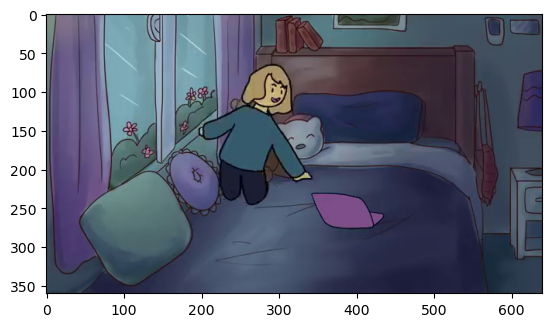

1/1 [==============================] - 2s 2s/step

 frame270.jpg : to to get from is bed her her


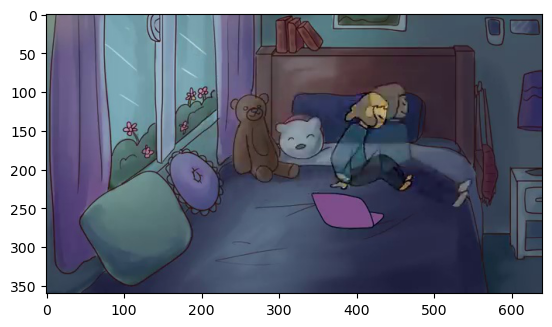

1/1 [==============================] - 2s 2s/step

 frame271.jpg : down from from bed the the the the


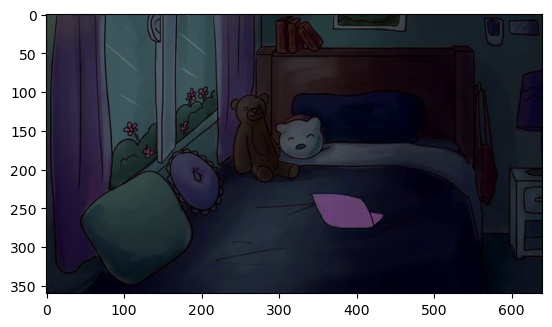

1/1 [==============================] - 2s 2s/step

 frame272.jpg : wearing her jacket jacket cone cone cone cone


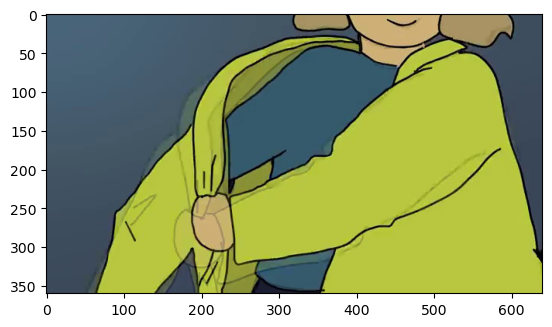

1/1 [==============================] - 2s 2s/step

 frame273.jpg : wearing her jacket hat cone cone cone cone


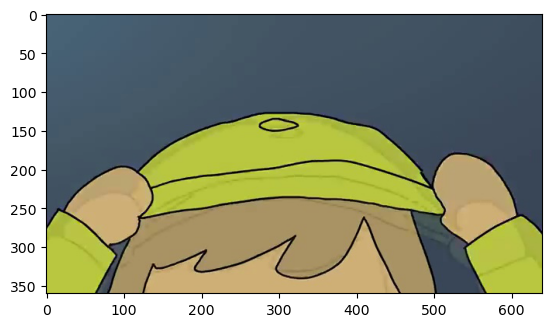

1/1 [==============================] - 2s 2s/step

 frame274.jpg : wearing her jacket jacket the cone cone cone


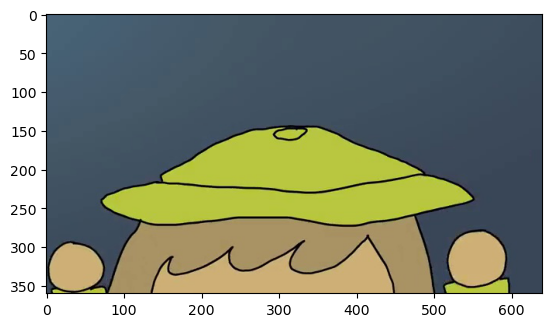

1/1 [==============================] - 2s 2s/step

 frame275.jpg : wearing her boots boots boots the cone cone


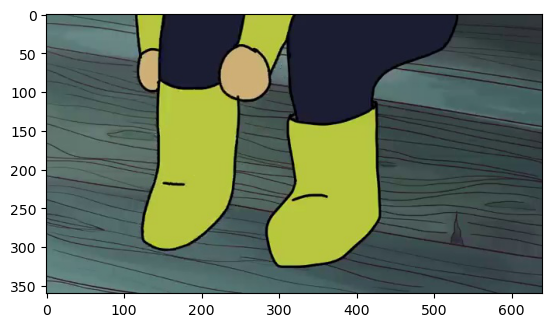

1/1 [==============================] - 2s 2s/step

 frame276.jpg : her boots boots boots boots the the the


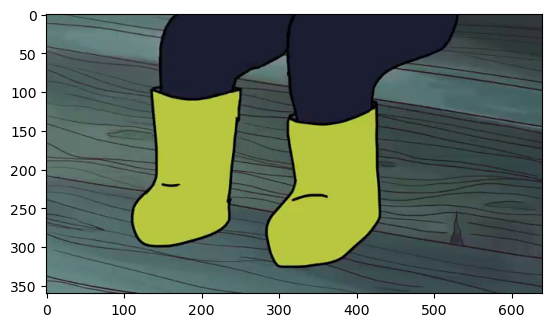

1/1 [==============================] - 2s 2s/step

 frame277.jpg : up is is somewhere somewhere is cone cone


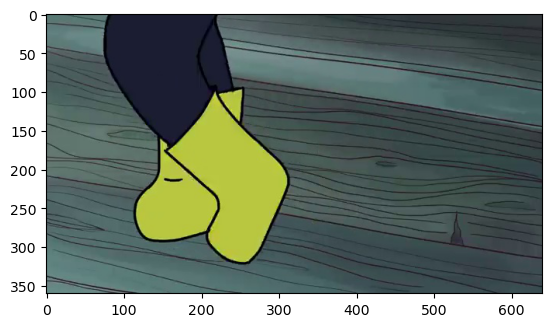

1/1 [==============================] - 2s 2s/step

 frame278.jpg : and is heading somewhere somewhere is cone cone


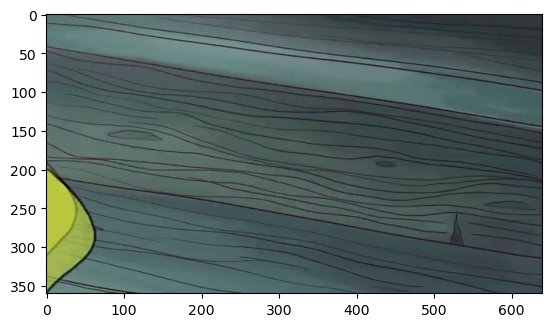

1/1 [==============================] - 2s 2s/step

 frame279.jpg : the door the is is is is it


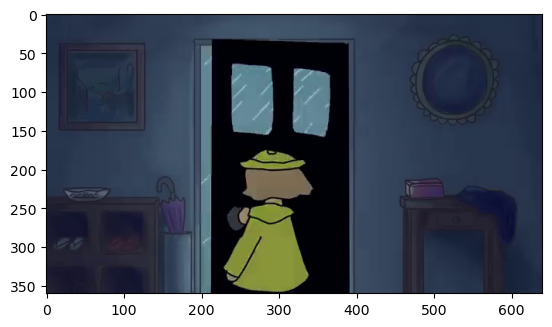

1/1 [==============================] - 2s 2s/step

 frame280.jpg : opened the door door the is is it


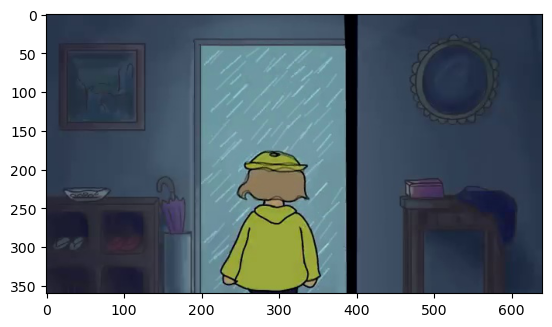

1/1 [==============================] - 2s 2s/step

 frame281.jpg : her her building in the the the the


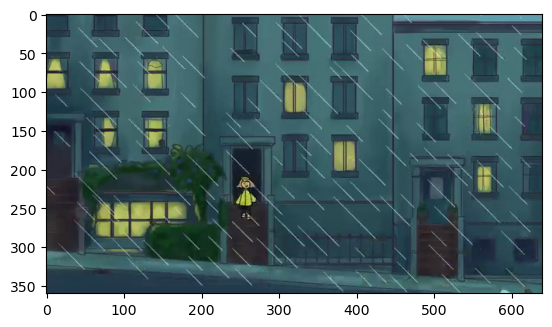

1/1 [==============================] - 2s 2s/step

 frame282.jpg : her her building in the the the the


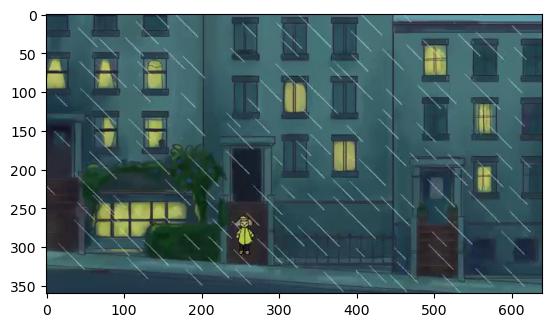

1/1 [==============================] - 2s 2s/step

 frame283.jpg : her her building in the the the the


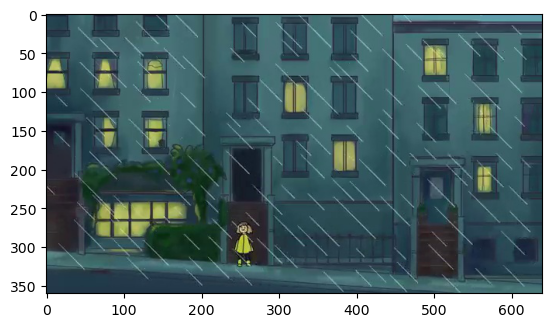

1/1 [==============================] - 2s 2s/step

 frame284.jpg : her her building in the the the the


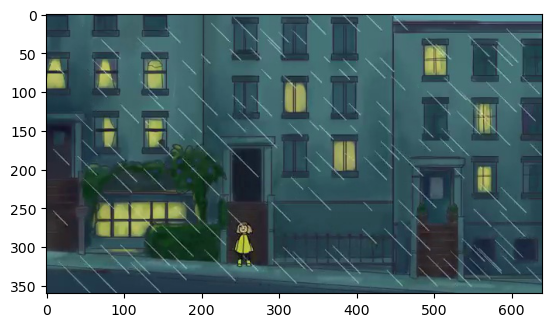

1/1 [==============================] - 2s 2s/step

 frame285.jpg : screen screen the the the it it the


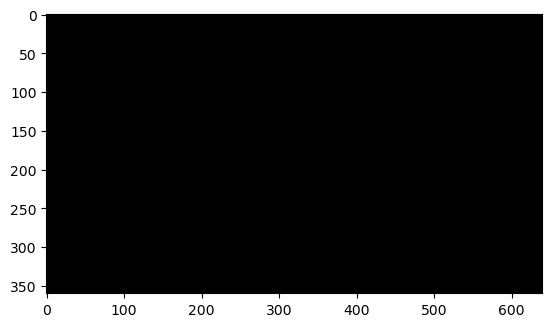

1/1 [==============================] - 2s 2s/step

 frame286.jpg : screen screen the the the it it the


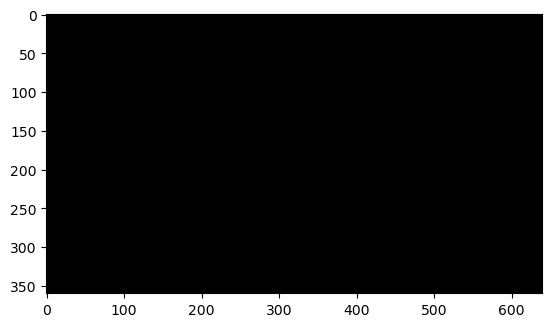

1/1 [==============================] - 2s 2s/step

 frame287.jpg : screen screen the the the it it the


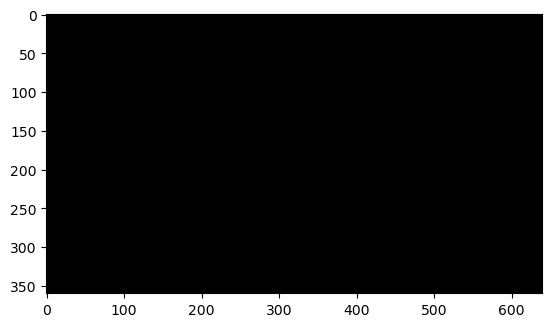

1/1 [==============================] - 2s 2s/step

 frame288.jpg : screen screen the the the it it the


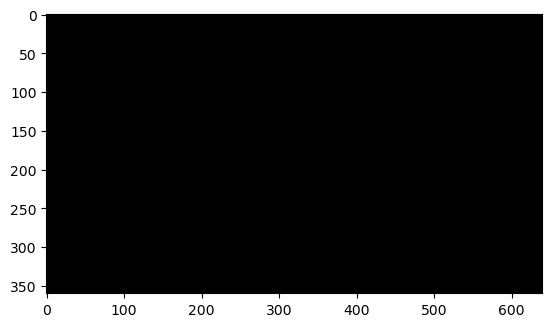

In [56]:
max_length = 14

tokenizer = load(open("tokenizer.p","rb"))

# model = load_model('models_v2/model_9.h5') # Change v2 to v3 or any new model folder if created and trained again

model = load_model('models_v3/model_9.h5') # Change v2 to v3 or any new model folder if created and trained again

xception_model = Xception(include_top=False, pooling="avg")

file=os.listdir('D:/nlp/videosummarization_dataset/test/videos/v1')
img_path=frame_extraction(file)

directory='D:/nlp/videosummarization_dataset/test/frames/v1' # Change this to the video u want

ct=0
full_sentence=''
for pic in os.listdir(directory):
    img_path = os.path.join(directory, pic)
    photo = extract_features(img_path)
    img = Image.open(img_path)
    description = generate_desc(model, tokenizer, photo, max_length)
    words_list = description.split()[2:10]
    sentence = ' '.join(words_list)
    full_sentence+=sentence
    print("\n", pic, ":", sentence)
    plt.imshow(img)
    plt.show()
    ct+=1

In [58]:
from transformers import pipeline
summarizer=pipeline('summarization')


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [59]:
summarizer(full_sentence)

[{'summary_text': ' Wearing her jacket jacket, cone cone conecones is heading somewhere somewhere . Wearing a hat, her jacket hat and her boots, the cone coneher boots boots boots are her boots . The idea idea is to get from from bed bed to her her down from bed .'}]

In [57]:
import nltk
ref_captions= [' girl looking at laptop during rain '],
gen_captions=['at laptop during during rain rain rain child']
score = nltk.translate.bleu_score.corpus_bleu(ref_captions, gen_captions)
print('BLEU score:', score)

BLEU score: 0.5630122356030381


In [5]:
train_path=os.listdir('D:/nlp/dataset/train')
